# Problem 3 - State Estimation

## Agenda
- Problem Description
- Problem Implementation
- Alternative Problems
- Wrap-Up

## Problem Description
- <b>Consider a grid for which we have sufficient metering data <i>z<sub>meter</sub></i> and discover the state vector <i>x</i> that fully characterizes the condition in which the grid is being operated, given the grid static information of its structure and corresponding component models.<b>

    _______________________________________________________________________________________________________________________

Considered "Kite" 5 Bus Network

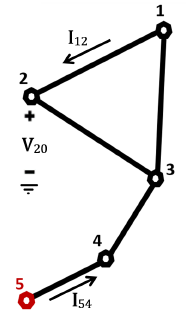

- <b>Implementation.<b>

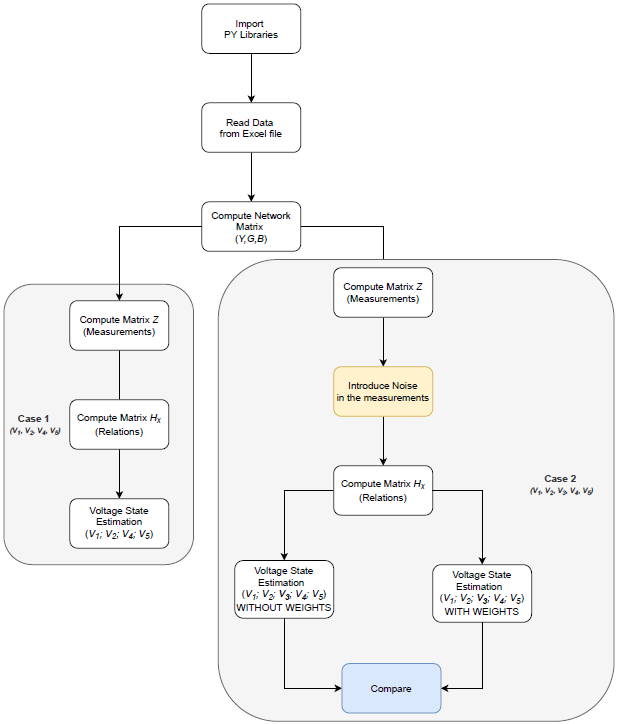

<b>Import Python Libraries

In [162]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

<b>Parameters

In [163]:
networkFactor = 100    # To change the characteristics of the network (Y)
cosPhi=0.95            # Value of teta
m=100                  # Number of Iterations   
sig=0.5                # Noise factor 

<b>Import data (From Excel file)

In [164]:
Info = np.array(pd.read_excel (r'DASG_Prob2_new.xlsx', sheet_name='Info', header=None))
# Information about the slack bus
SlackBus=Info[0,1]
print ("Slack Bus: ", SlackBus,"\n")

# Network Information
Net_Info = np.array(pd.read_excel (r'DASG_Prob2_new.xlsx', sheet_name='Y_Data'))
print ("Lines information (Admitances)\n", Net_Info, "\n")

#Power Information (train)
Power_Info = np.array(pd.read_excel (r'DASG_Prob2_new.xlsx', sheet_name='Load(t,Bus)'))
Power_Info = np.delete(Power_Info,[0],1)
print ("Power consumption information (time, Bus) - (Train)\n", Power_Info, "\n")

time=Power_Info.shape[0]
P = np.dot(-Power_Info,np.exp(complex(0,1)*np.arccos(cosPhi)))
I=np.conj(P[2,:])

Slack Bus:  5 

Lines information (Admitances)
 [[1 2 '0,01-0,1i']
 [1 3 '0,02-0,2i']
 [2 3 '0,03-0,2i']
 [3 4 '0,03-0,2i']
 [4 5 '0,02-0,2i']] 

Power consumption information (time, Bus) - (Train)
 [[0.332 0.064 0.084 0.12 ]
 [0.236 0.164 0.276 0.064]
 [0.224 0.708 1.572 0.072]
 [0.36  3.44  1.188 0.18 ]
 [1.332 2.176 0.484 1.464]
 [1.516 3.02  0.316 0.624]
 [0.92  0.916 0.404 2.772]
 [0.752 0.64  0.396 1.464]
 [1.828 0.684 0.576 0.576]
 [3.568 0.564 0.828 0.428]
 [0.78  0.356 0.728 0.348]
 [0.856 0.22  0.308 0.12 ]
 [0.684 0.528 0.256 0.44 ]] 



<b>Admittance Matrix(Y); Conductance Matrix(G); Susceptance Matrix(B)

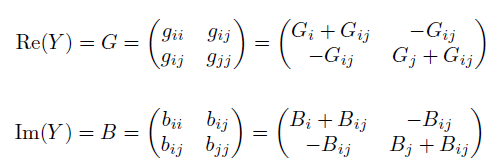

In [165]:
# Determine the number of Bus
nBus=max(np.max(Net_Info[:,0]),np.max(Net_Info[:,1]))

# Create the variable number of lines and the admitance matrix (Y)
nLines=Net_Info.shape[0]

Y=np.zeros((nBus,nBus), dtype=complex)

#Complete the Y matrix nad update the number of lines
for i in range (Net_Info.shape[0]):
    y_aux=Net_Info[i,2].replace(",",".")
    y_aux=y_aux.replace("i","j")
    Y[Net_Info[i,0]-1,Net_Info[i,0]-1]=Y[Net_Info[i,0]-1,Net_Info[i,0]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,1]-1]=Y[Net_Info[i,1]-1,Net_Info[i,1]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,0]-1,Net_Info[i,1]-1]=Y[Net_Info[i,0]-1,Net_Info[i,1]-1]-complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,0]-1]=Y[Net_Info[i,1]-1,Net_Info[i,0]-1]-complex(y_aux)*networkFactor

            
# Remove the slack bus from the admitance matrix            
Yl=np.delete(Y, np.s_[SlackBus-1], axis=0)
Yl=np.delete(Yl, np.s_[SlackBus-1], axis=1)

# Conductance Matrix
G=Yl.real

# Susceptance Matrix
B=Yl.imag 

print("The admitance matrix Y is:\n", Y, "\n")
print("The conductance matrix G is\n", G, "\n")
print("The susceptance matrix B is\n",B, "\n")

The admitance matrix Y is:
 [[ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]] 

The conductance matrix G is
 [[ 3. -1. -2.  0.]
 [-1.  4. -3.  0.]
 [-2. -3.  8. -3.]
 [ 0.  0. -3.  5.]] 

The susceptance matrix B is
 [[-30.  10.  20.   0.]
 [ 10. -30.  20.   0.]
 [ 20.  20. -60.  20.]
 [  0.   0.  20. -40.]] 



<b>1º State Estimation considering complete information about currents <i>I<sub>12</sub></i> and <i>I<sub>54</sub></i> (amplitude and angle) and not estimating <i>V<sub>3</sub></i>; Page 39

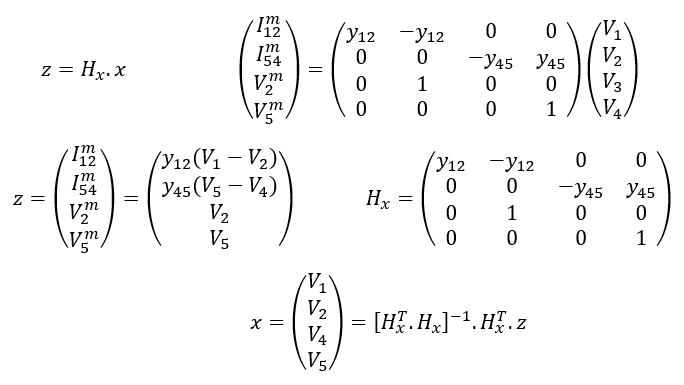

In [166]:
# Matrix Creation
b0s=np.zeros((4), dtype=complex)
A0s=np.zeros((4,4), dtype=complex)
v0s=np.zeros((5), dtype=complex)

# Voltage Computing (Reference)
v0s[0:4]=1+np.dot(LA.inv(Yl),I)
v0s[4]=1 # V5 = 1/_0 V

# Measurement values z 
z = np.zeros((4), dtype = complex)
z[0] = Y[0,1] * (v0s[0] - v0s[1])
z[1] = Y[3,4] * (v0s[4] - v0s[3])
z[2] = v0s[1]
z[3] = v0s[4]

# Matrix Hx 
H_x = np.zeros((4,4), dtype=complex)
H_x[0] = [Y[0,1], -Y[0,1], 0, 0]
H_x[1] = [0, 0, -Y[3,4], Y[3,4]]
H_x[2] = [0, 1, 0, 0]
H_x[3] = [0, 0, 0, 1]

#State Variables (x) - These variables are the estimated voltages (V1; V2; V4; V5)
x = np.zeros((4), dtype=complex)
x = np.linalg.inv(H_x.conj().T @ H_x) @ H_x.conj().T @ z

print(v0s)
print('Y:\n', Y)
print('\nHx:\n', H_x)
print('\nx:\n',x)

[0.88512062-0.24325601j 0.87962652-0.25388267j 0.89238371-0.22775428j
 0.94806556-0.11716656j 1.        +0.j        ]
Y:
 [[ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]]

Hx:
 [[-1.+10.j  1.-10.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  2.-20.j -2.+20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j]]

x:
 [0.88512062-0.24325601j 0.87962652-0.25388267j 0.94806556-0.11716656j
 1.        +0.j        ]


<b>2º State Estimation considering RMS information of currents <i>I<sub>12</sub></i> and <i>I<sub>54</sub></i> and estimating <i>V<sub>3</sub></i>. Page 41
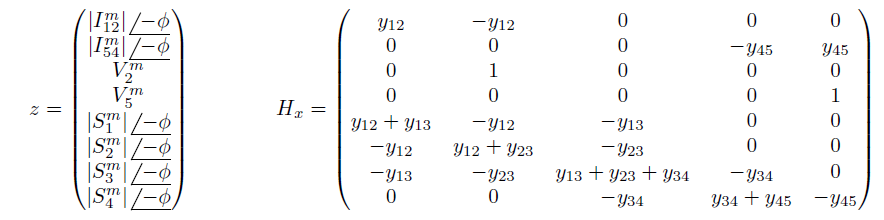

In [167]:
# Matrix Creation
z0=np.zeros((8), dtype=complex)
z1=np.zeros((8), dtype=complex)
z2=np.zeros((8), dtype=complex)
# A=np.zeros((8,5), dtype=complex)
v=np.zeros((5), dtype=complex)

# Voltage Computing (Reference)
v[0:4]=1+np.dot(np.linalg.inv(Yl),I)
v[4]=1

# Measurement values z (In that case, we are computing the currents and voltages but we can also measure them).
z0[0] = np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z0[1] = np.dot(np.absolute(np.dot(-Y[3,4],(v[4]-v[3]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z0[2] = v[1]
z0[3] = v[4]
z0[4:8] = I #In that case, we are also including the vectors of aparente power

# Matrix Hx (Page 41)
Hx = np.zeros((8,5), dtype=complex)
Hx[0] = [Y[0,1], -Y[0,1], 0, 0, 0]
Hx[1] = [0, 0, 0, -Y[3,4], Y[3,4]]
Hx[2] = [0, 1, 0, 0, 0]
Hx[3] = [0, 0, 0, 0, 1]
Hx[4] = [Y[0,1]+Y[0,2], -Y[0,1], -Y[0,2], 0, 0]
Hx[5] = [-Y[0,1], Y[0,1]+Y[1,2], -Y[1,2], 0, 0]
Hx[6] = [-Y[0,2], -Y[1,2], Y[0,2]+Y[1,2]+Y[2,3], -Y[2,3], 0]
Hx[7] = [0, 0, -Y[2,3], Y[2,3]+Y[3,4], -Y[3,4]]

print('z0:\n', z0)
print('\nHx:\n', Hx)

z0:
 [ 0.1142144 -0.03754046j  2.4472    -0.80435574j  0.87962652-0.25388267j
  1.        +0.j         -0.2128    +0.06994398j -0.6726    +0.22107293j
 -1.4934    +0.49085684j -0.0684    +0.02248199j]

Hx:
 [[-1.+10.j  1.-10.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  2.-20.j -2.+20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [-3.+30.j  1.-10.j  2.-20.j  0. +0.j  0. +0.j]
 [ 1.-10.j -4.+30.j  3.-20.j  0. +0.j  0. +0.j]
 [ 2.-20.j  3.-20.j -8.+60.j  3.-20.j  0. +0.j]
 [ 0. +0.j  0. +0.j  3.-20.j -5.+40.j  2.-20.j]]


<b>2º a) - First, the weight of pseudo-measurements (Matrix W) <u>are not considered</u>;

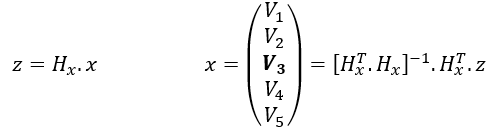

In [168]:
#Noise to be added to peseudo-measurements
e = np.random.normal(0.0, 1.0, size=(4,m))*sig

#Estimation not considering the noise 
x0 = np.linalg.inv(Hx.conj().T @ Hx) @ Hx.conj().T @ z0

#Matrix creation
z1 = np.zeros((8), dtype=complex)
z1[0] = np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z1[1] = np.dot(np.absolute(np.dot(-Y[3,4],(v[4]-v[3]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z1[2] = v[1]
z1[3] = v[4]
z1[4:8] = I


sx = np.zeros(5, dtype=complex)
rms = np.zeros((5,m), dtype=complex)
ei12a = np.zeros(m)
ei54a = np.zeros(m)

for i in range(m):
    #Introduce error in the measurements (Matrix z)
    z1[4:8] = I + e[:,i]
    
    #Estimate the voltages based on measurements with the errors
    x = np.linalg.inv(Hx.conj().T @ Hx) @ Hx.conj().T @ z1

    #Accumulated value of estimations
    sx += x

    #Errors in the voltages
    rms[:,i] = np.sqrt(np.dot((x - x0), np.conjugate(x - x0))) 
    # x0 is the initial estimation not considering the noise 
    # x is the estimation considering the noise

    #Relative current errors (To be used in the graphics)
    ei12a[i]=np.divide(np.absolute(np.dot(Y[0,1],(x[0]-x[1])))-np.absolute(np.dot(Y[0,1],(v[0]-v[1]))),np.absolute(np.dot(Y[0,1],(v[0]-v[1]))))
    ei54a[i]=np.divide(np.absolute(np.dot(Y[3,4],(1-x[3])))-np.absolute(np.dot(Y[3,4],(1-v[3]))),np.absolute(np.dot(Y[3,4],(1-v[3]))))

#Average Voltage Estimation
x_avg = sx / m

#Average Voltage RMS Error
ee = np.transpose(np.matrix, sum(np.transpose(rms))) / m

print('x0:\n', x0)
print('x:\n', x)
print('\navg X:\n', x_avg)
print('\nAverage Voltage RMS Error:\n', ee)

x0:
 [0.99392608-0.01201236j 0.99927486-0.00148388j 0.98685131-0.02700336j
 0.93183637-0.13624j    0.88035166-0.25239878j]
x:
 [0.99348688-0.01586893j 0.9992536 -0.00207796j 0.98628775-0.03152131j
 0.9315209 -0.1390518j  0.88037292-0.2518047j ]

avg X:
 [0.99313261-0.0184958j  0.99854171-0.00681018j 0.98646419-0.0297657j
 0.93239452-0.13268093j 0.88108482-0.24707248j]

Average Voltage RMS Error:
 [0.03413902+0.j 0.03413902+0.j 0.03413902+0.j 0.03413902+0.j
 0.03413902+0.j]


<b>2º b) - Second, the weight of pseudo-measurements (Matrix W) <u>are considered</u>;
    
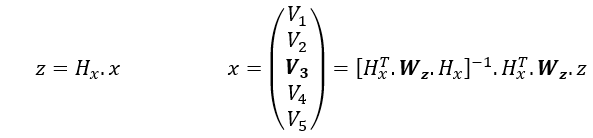

In [169]:
# The vector of errors is the same used in the first scenario 

#Matriz of the Weights (W)
w_diag = np.repeat([0.001, sig], 4)**-2 # repeated weights vector
W = np.diag(w_diag)

#Estimation not considering the noise, but considering the weight
x0_W = np.linalg.inv(Hx.conj().T @ W @ Hx) @ Hx.conj().T @ W @ z0
print('\nx0 with weights:\n', x0_W)

z2 = np.zeros((8), dtype=complex)
z2[0] = np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z2[1] = np.dot(np.absolute(np.dot(-Y[3,4],(v[4]-v[3]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z2[2] = v[1]
z2[3] = v[4]
# z2[4:8] = I

sx_W = np.zeros(5, dtype=complex)
rms_W = np.zeros((5,m), dtype=complex)
ei12a_W = np.zeros(m)
ei54a_W = np.zeros(m)
for i in range(m):
    #Introduce error in the measurements (Matrix z)
    z2[4:8] = I + e[:, i]

    #Estimate the voltages based on measurements with the errors
    x_W = np.linalg.inv(Hx.conj().T @ W @ Hx) @ Hx.conj().T @ W @ z2

    #Accumulated value of estimations
    sx_W += x_W

    #Errors in the voltages
    rms_W[:,i] = np.sqrt(np.dot((x_W - x0_W), np.conjugate(x_W - x0_W)))

    #Relative current errors (To be used in the graphics)
    ei12a_W[i] = np.divide(np.absolute(np.dot(Y[0,1], (x_W[0] - x_W[1]))) - np.absolute(np.dot(Y[0,1],(v[0]-v[1]))), np.absolute(np.dot(Y[0,1],(v[0]-v[1]))))
    ei54a_W[i] = np.divide(np.absolute(np.dot(Y[3,4],(x_W[4] - x_W[3]))) - np.absolute(np.dot(Y[3,4],(1-v[3]))), np.absolute(np.dot(Y[3,4],(1-v[3]))))
    
#Average Voltage Estimation
x_avg_W = sx_W / m
# print(x_avg_W)

#Average Voltage RMS Error
ee_W = np.absolute(np.transpose(np.matrix, sum(np.transpose(rms_W))) / m)

print('\nx with weights:\n', x_W)
# print('\navg X:\n', x_avg_W)
print('\nAverage Voltage RMS Error:\n', ee_W)


x0 with weights:
 [0.87504128-0.26426497j 0.87988766-0.25333099j 0.94555671-0.10924634j
 1.05167207+0.11661213j 0.99973886-0.00055168j]

x with weights:
 [0.87504193-0.26426076j 0.87988832-0.25332669j 0.94530434-0.11106631j
 1.05167141+0.11660779j 0.9997382 -0.00055598j]

Average Voltage RMS Error:
 [0.00539258 0.00539258 0.00539258 0.00539258 0.00539258]


<b>Plot Results

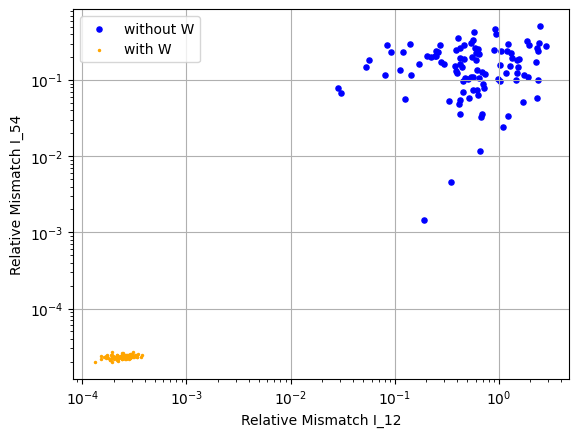

In [170]:
# Create scatter plot with logarithmic scale
plt.scatter(abs(ei12a), abs(ei54a), color='blue', label='without W', s = np.absolute(ee.mean())*400)
plt.scatter(abs(ei12a_W), abs(ei54a_W), color='orange', label='with W', s = np.absolute(ee_W.mean())*400)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-6, 10)
# plt.ylim(1e-6, 10)
plt.xlabel('Relative Mismatch I_12')
plt.ylabel('Relative Mismatch I_54')
# plt.title('relative Mismatch')
plt.legend()
plt.grid(True)
plt.show()

# Extra Project Goals
Think about an interesting variation to this problem or a different way to solve and implement it !!!

Some ideas:
- Assume you have to chose just two out of four possible pseudo-measurements, S<sup>m</sup><sub>1</sub> , S<sup>m</sup><sub>2</sub> , S<sup>m</sup><sub>3</sub> , S<sup>m</sup><sub>4</sub> . What would be your choices and why? Chose based on probable accuracy of the resulting estimation.
- Assume that <i>I<sub>12</sub>=0</i>. Under this assumption, one of two possible situations may be occuring: either branch 1-2 is out of service (<i>y<sub>12</sub>=0</i>) or the corresponding current meter is malfunctioning. Decide about the most probable situation based on the accuracy of the corresponding estimation. as in the previous exercice, use the matrix <i>R<sub>x</sub></i> andd consider different matrices <i>W<sub>z</sub></i> including the identity matrix. Elaborate on the effects of <i>W<sub>z</sub></i>.  


#### Choose 2 out of 4 possible pseudo-measurements (S<sup>m</sup><sub>1</sub> , S<sup>m</sup><sub>2</sub> , S<sup>m</sup><sub>3</sub> , S<sup>m</sup><sub>4</sub>)

In [171]:
from itertools import combinations

S_comb = list(combinations([4, 5, 6, 7], 2)) # lists all pairs of combinations of Sm in Hx
# print(S_comb)

w_diag = np.repeat([0.001, 0.001, sig], 2)**-2 # repeated weights vector
# print(w_diag)
W = np.diag(w_diag)

Hx_s = np.zeros((len(S_comb), 5), dtype=complex)
Hx_s[0:4] = Hx[0:4]
# print(Hx_s)

z3 = np.zeros((6), dtype=complex)
z3[0] = np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z3[1] = np.dot(np.absolute(np.dot(-Y[3,4],(v[4]-v[3]))), np.exp(complex(0,-1) * np.arccos(cosPhi)))
z3[2] = v[1]
z3[3] = v[4]

ei12a_W = np.zeros((m,6))
ei54a_W = np.zeros((m,6))

for j, unknown_indices in enumerate(S_comb):
    # Hx_s[0:4,:] = Hx[0:4,:]
    Hx_s[4,:] = Hx[unknown_indices[0],:]
    Hx_s[5,:] =Hx[unknown_indices[1],:]

    for i in range(m):
        #Introduce error in the measurements (Matrix z) 
        z3[4] = I[unknown_indices[0]-4] + e[unknown_indices[0]-4, i]
        z3[5] = I[unknown_indices[1]-4] + e[unknown_indices[1]-4, i]
        
        x_W = np.linalg.inv(Hx_s.conj().T @ W @ Hx_s) @ Hx_s.conj().T @ W @ z3

        #Accumulated value of estimations
        sx_W += x_W

        #Errors in the voltages
        rms_W[:,i] = np.sqrt(np.dot((x_W - x0_W), np.conjugate(x_W - x0_W)))

        #Relative current errors (To be used in the graphics)
        ei12a_W[i,j] = np.divide(np.absolute(np.dot(Y[0,1], (x_W[0] - x_W[1]))) - np.absolute(np.dot(Y[0,1],(v[0]-v[1]))), np.absolute(np.dot(Y[0,1],(v[0]-v[1]))))
        ei54a_W[i,j] = np.divide(np.absolute(np.dot(Y[3,4],(x_W[4] - x_W[3]))) - np.absolute(np.dot(Y[3,4],(1-v[3]))), np.absolute(np.dot(Y[3,4],(1-v[3]))))
    
    #Average Voltage Estimation
    x_avg_W = sx_W / m
    # print(x_avg_W)
    #Average Voltage RMS Error
    ee_W = np.transpose(np.matrix,sum(np.transpose(rms_W))) / m

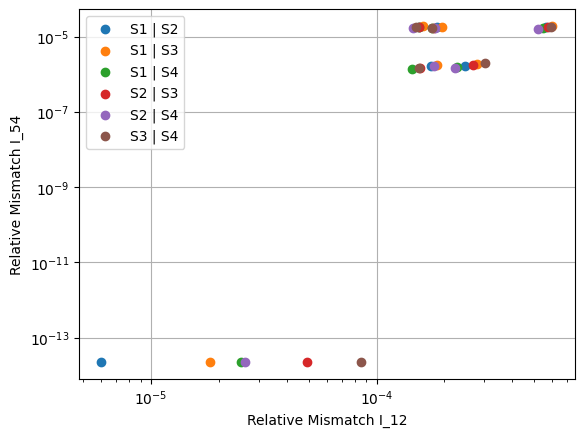

In [172]:
Sm_dict = dict(zip([4, 5, 6, 7], ['S1', 'S2', 'S3', 'S4']))
# print(Sm_dict)

for j, unknown_indices in enumerate(S_comb):
    plt.scatter(abs(ei12a_W[j]), abs(ei54a_W[j]),
    label=f"{Sm_dict[unknown_indices[0]]} | {Sm_dict[unknown_indices[1]]}")

plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-6, 10)
#plt.ylim(1e-6, 10)
plt.xlabel('Relative Mismatch I_12')
plt.ylabel('Relative Mismatch I_54')
# plt.title('Scatter Plot with Logarithmic Scale')
plt.legend()
plt.grid(True)
plt.show()